Creating IoT Dashboard and Individual Sensor Charts...
Data loaded: 330 records from 100 packages
Building comprehensive dashboard...


Dashboard saved as 'iot_comprehensive_dashboard.html'

Creating individual Plotly charts with danger levels...
Processing temperature Plotly chart...


Saved: temperature_plotly_danger.html
Processing humidity Plotly chart...


Saved: humidity_plotly_danger.html
Processing shock Plotly chart...


Saved: shock_plotly_danger.html

Creating individual Seaborn clean charts...
Processing temperature Seaborn chart...


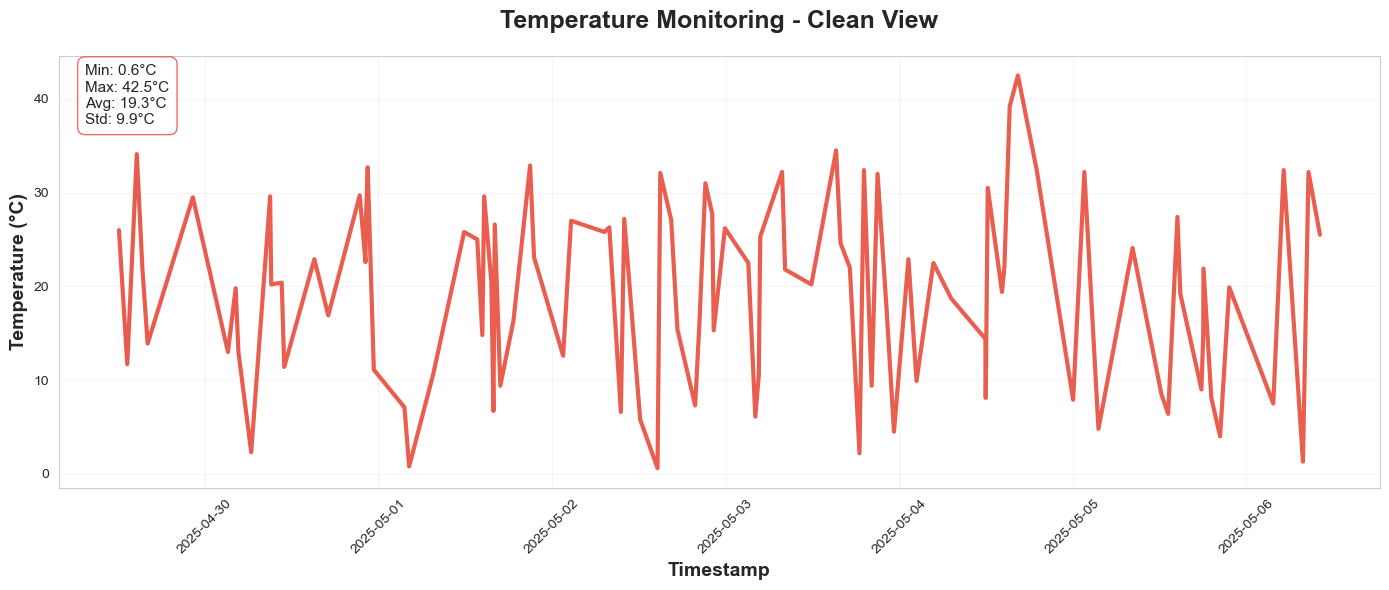

Saved: temperature_seaborn_clean.png
Processing humidity Seaborn chart...


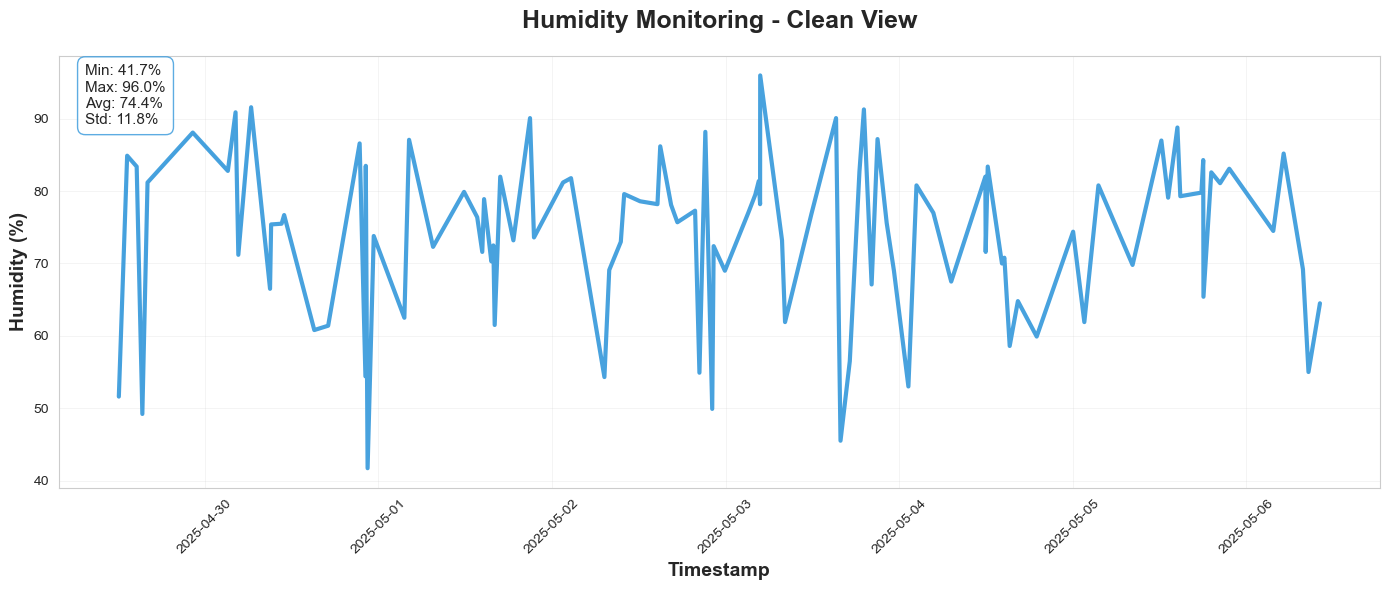

Saved: humidity_seaborn_clean.png
Processing shock Seaborn chart...


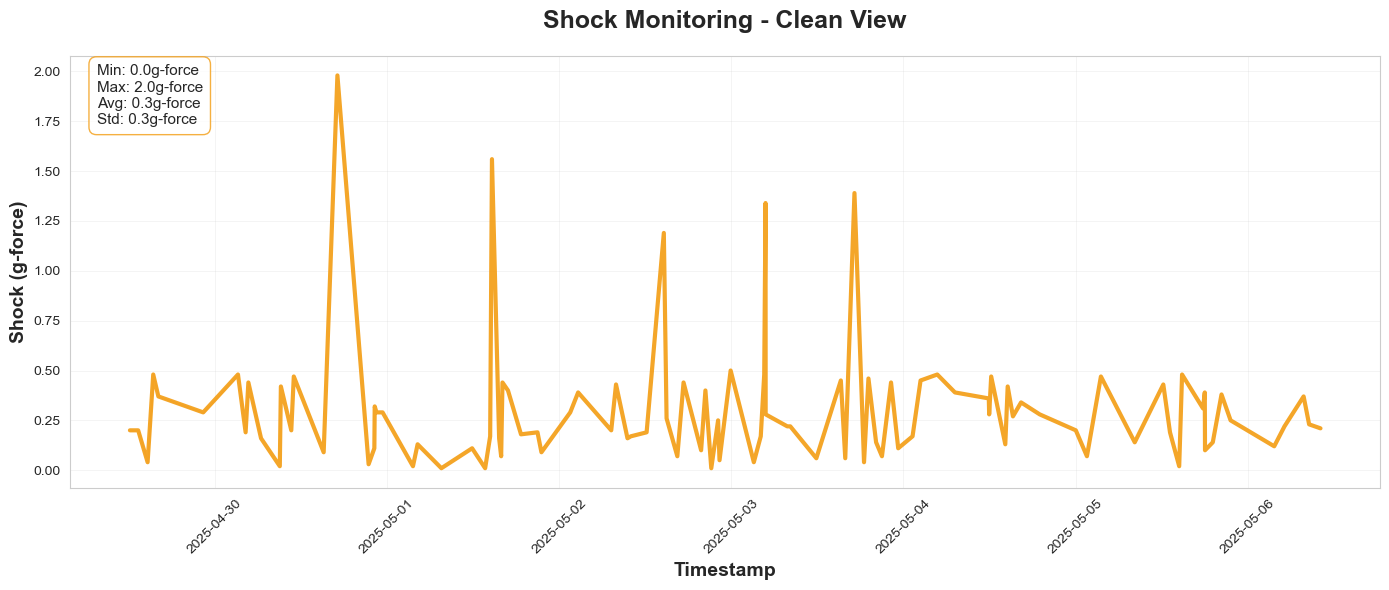

Saved: shock_seaborn_clean.png

SUMMARY - All charts created successfully!
COMPREHENSIVE DASHBOARD:
   iot_comprehensive_dashboard.html - Full monitoring dashboard

INDIVIDUAL PLOTLY CHARTS (with danger levels):
   temperature_plotly_danger.html
   humidity_plotly_danger.html
   shock_plotly_danger.html

INDIVIDUAL SEABORN CHARTS (clean view):
   temperature_seaborn_clean.png
   humidity_seaborn_clean.png
   shock_seaborn_clean.png

TOTAL FILES GENERATED:
   Interactive HTML files: 4 (Plotly)
   High-quality PNG files: 3 (Seaborn)

Use HTML files for interactive exploration
Use PNG files for reports and presentations


In [10]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

print("Creating IoT Dashboard and Individual Sensor Charts...")
print("=" * 60)

# Load and prepare data
df = pd.read_csv("cleaned_iot_data.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values('timestamp')

print(f"Data loaded: {len(df)} records from {df['device_id'].nunique()} packages")

# Define danger thresholds and colors
DANGER_THRESHOLDS = {
    'temperature': 35,    # Danger above 35°C
    'humidity': 90,       # Danger above 90%
    'shock': 1.0         # Danger above 1.0g
}

color_map = {
    'temperature': '#E74C3C',    # Red
    'humidity': '#3498DB',       # Blue  
    'shock': '#F39C12'           # Orange
}

# Get sensor types
sensor_types = df['data_type'].unique()

# =============================================================================
# COMPREHENSIVE DASHBOARD
# =============================================================================

print("Building comprehensive dashboard...")

# Create 6-panel dashboard
fig_dashboard = make_subplots(
    rows=3, cols=3,
    subplot_titles=(
        'Combined Sensors Timeline', '', 'Active Monitoring',
        'Temperature Readings', 'Humidity Readings', 'Shock Readings',
        'Danger Incident Logs', '', 'Risk by Location'
    ),
    specs=[
        [{"colspan": 2}, None, {}],  # Row 1: Combined (2 cols) + Active metrics
        [{}, {}, {}],                 # Row 2: 3 individual sensor charts
        [{"colspan": 2}, None, {}]    # Row 3: Danger logs (2 cols) + Risk location
    ],
    vertical_spacing=0.08,
    horizontal_spacing=0.05
)

# 1. Combined sensors timeline
for sensor_type in sensor_types:
    sensor_data = df[df['data_type'] == sensor_type]
    
    hover_text = f'<b>{sensor_type.title()}</b><br>Time: %{{x}}<br>Value: %{{y:.2f}}<br>Package: %{{text}}<br>City: %{{customdata}}<extra></extra>'
    
    fig_dashboard.add_trace(
        go.Scatter(
            x=sensor_data['timestamp'],
            y=sensor_data['numeric_value'],
            mode='lines+markers',
            name=sensor_type.title(),
            line=dict(color=color_map.get(sensor_type), width=3),
            marker=dict(size=4, opacity=0.6),
            text=sensor_data['device_id'],
            customdata=sensor_data['closest_city'],
            hovertemplate=hover_text
        ),
        row=1, col=1
    )

# Add danger threshold lines
for sensor_type, threshold in DANGER_THRESHOLDS.items():
    if sensor_type in sensor_types:
        fig_dashboard.add_hline(
            y=threshold, 
            line_dash="dash", 
            line_color="red", 
            line_width=2,
            opacity=0.7,
            row=1, col=1
        )

# 2. Active monitoring metrics
danger_incidents = []
for sensor_type, threshold in DANGER_THRESHOLDS.items():
    sensor_data = df[df['data_type'] == sensor_type]
    danger_readings = sensor_data[sensor_data['numeric_value'] > threshold]
    
    for _, incident in danger_readings.iterrows():
        danger_incidents.append({
            'timestamp': incident['timestamp'],
            'package_id': incident['device_id'],
            'sensor_type': sensor_type,
            'value': incident['numeric_value'],
            'threshold': threshold,
            'location': incident['closest_city'],
            'severity': 'HIGH' if incident['numeric_value'] > threshold * 1.2 else 'MEDIUM'
        })

danger_df = pd.DataFrame(danger_incidents)

active_counts = {
    'total_packages': df['device_id'].nunique(),
    'total_readings': len(df),
    'danger_incidents': len(danger_df),
    'cities_affected': danger_df['location'].nunique() if len(danger_df) > 0 else 0,
    'high_risk_packages': danger_df['package_id'].nunique() if len(danger_df) > 0 else 0
}

metrics_text = f"""
<b>ACTIVE MONITORING</b><br><br>
Total Packages: {active_counts['total_packages']}<br>
Total Readings: {active_counts['total_readings']}<br>
Danger Incidents: {active_counts['danger_incidents']}<br>
Cities Affected: {active_counts['cities_affected']}<br>
High Risk Packages: {active_counts['high_risk_packages']}<br><br>

<b>STATUS:</b><br>
{"NORMAL" if active_counts['danger_incidents'] < 10 else "HIGH ALERT"}
"""

fig_dashboard.add_trace(
    go.Scatter(
        x=[0.5], y=[0.5],
        mode='text',
        text=metrics_text,
        textfont=dict(size=14, family="monospace"),
        showlegend=False,
        hoverinfo='skip'
    ),
    row=1, col=3
)

# 3. Individual sensor charts
sensor_positions = [(2, 1), (2, 2), (2, 3)]

for i, sensor_type in enumerate(sensor_types):
    if i < 3:
        sensor_data = df[df['data_type'] == sensor_type]
        row, col = sensor_positions[i]
        
        hover_text = f'<b>{sensor_type.title()}</b><br>Time: %{{x}}<br>Value: %{{y:.2f}}<br>Package: %{{text}}<br>City: %{{customdata}}<extra></extra>'
        
        fig_dashboard.add_trace(
            go.Scatter(
                x=sensor_data['timestamp'],
                y=sensor_data['numeric_value'],
                mode='lines',
                name=f'{sensor_type.title()} Detail',
                line=dict(color=color_map.get(sensor_type), width=3),
                showlegend=False,
                text=sensor_data['device_id'],
                customdata=sensor_data['closest_city'],
                hovertemplate=hover_text
            ),
            row=row, col=col
        )
        
        # Add danger threshold
        if sensor_type in DANGER_THRESHOLDS:
            threshold = DANGER_THRESHOLDS[sensor_type]
            fig_dashboard.add_hline(
                y=threshold, 
                line_dash="dash", 
                line_color="red",
                line_width=2,
                row=row, col=col
            )
            
            # Highlight danger points
            danger_points = sensor_data[sensor_data['numeric_value'] > threshold]
            if len(danger_points) > 0:
                fig_dashboard.add_trace(
                    go.Scatter(
                        x=danger_points['timestamp'],
                        y=danger_points['numeric_value'],
                        mode='markers',
                        marker=dict(
                            color='red',
                            size=10,
                            symbol='x'
                        ),
                        name=f'{sensor_type.title()} Danger',
                        showlegend=False,
                        hovertemplate=f'<b>DANGER: {sensor_type.title()}</b><br>Time: %{{x}}<br>Value: %{{y:.2f}}<br>Threshold: {threshold}<extra></extra>'
                    ),
                    row=row, col=col
                )

# 4. Danger incident logs
if len(danger_df) > 0:
    log_text = "<b>RECENT DANGER INCIDENTS</b><br><br>"
    recent_dangers = danger_df.sort_values('timestamp', ascending=False).head(10)
    
    for _, incident in recent_dangers.iterrows():
        time_str = incident['timestamp'].strftime("%m/%d %H:%M")
        log_text += f"<b>{time_str}</b> | {incident['package_id']} | "
        log_text += f"<span style='color: {color_map.get(incident['sensor_type'], 'red')}'>"
        log_text += f"{incident['sensor_type'].upper()}: {incident['value']:.1f}</span> "
        log_text += f"(>{incident['threshold']}) | {incident['location']} | "
        log_text += f"<b style='color: {'red' if incident['severity'] == 'HIGH' else 'orange'}'>{incident['severity']}</b><br>"
    
    if len(danger_df) > 10:
        log_text += f"<br>... and {len(danger_df) - 10} more incidents"
else:
    log_text = "<b>DANGER INCIDENT LOGS</b><br><br>No danger incidents detected!<br>All sensor readings within safe thresholds."

fig_dashboard.add_trace(
    go.Scatter(
        x=[0.1], y=[0.5],
        mode='text',
        text=log_text,
        textfont=dict(size=11, family="monospace"),
        showlegend=False,
        hoverinfo='skip'
    ),
    row=3, col=1
)

# 5. Risk by location
if len(danger_df) > 0:
    city_risk = danger_df.groupby('location').agg({
        'package_id': 'nunique',
        'value': 'count'
    }).reset_index()
    city_risk.columns = ['City', 'Packages_Affected', 'Total_Incidents']
    city_risk = city_risk.sort_values('Total_Incidents', ascending=True).tail(8)
    
    fig_dashboard.add_trace(
        go.Bar(
            y=city_risk['City'],
            x=city_risk['Total_Incidents'],
            orientation='h',
            marker_color='red',
            showlegend=False,
            hovertemplate='<b>%{y}</b><br>Incidents: %{x}<br>Packages: %{customdata}<extra></extra>',
            customdata=city_risk['Packages_Affected']
        ),
        row=3, col=3
    )
else:
    fig_dashboard.add_trace(
        go.Scatter(
            x=[0.5], y=[0.5],
            mode='text',
            text="NO HIGH-RISK LOCATIONS<br><br>All cities operating<br>within safe parameters",
            textfont=dict(size=14, family="monospace"),
            showlegend=False,
            hoverinfo='skip'
        ),
        row=3, col=3
    )

# Update layout
fig_dashboard.update_layout(
    title={
        'text': 'IoT Logistics Comprehensive Monitoring Dashboard',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 24, 'family': 'Arial, sans-serif', 'color': '#2C3E50'}
    },
    height=1200,
    plot_bgcolor='white',
    paper_bgcolor='#F8F9FA',
    hovermode='closest',
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

# Update axes styling
fig_dashboard.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig_dashboard.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

# Remove axes for text displays
fig_dashboard.update_xaxes(showgrid=False, showticklabels=False, row=1, col=3)
fig_dashboard.update_yaxes(showgrid=False, showticklabels=False, row=1, col=3)
fig_dashboard.update_xaxes(showgrid=False, showticklabels=False, row=3, col=1)
fig_dashboard.update_yaxes(showgrid=False, showticklabels=False, row=3, col=1)

# Save dashboard
fig_dashboard.write_html("iot_comprehensive_dashboard.html")
fig_dashboard.show()

print("Dashboard saved as 'iot_comprehensive_dashboard.html'")

# =============================================================================
# INDIVIDUAL SENSOR CHARTS - PLOTLY WITH DANGER LEVELS
# =============================================================================

print("\nCreating individual Plotly charts with danger levels...")

unit_map = {'temperature': '°C', 'humidity': '%', 'shock': 'g-force'}

for sensor_type in sensor_types:
    print(f"Processing {sensor_type} Plotly chart...")
    
    sensor_data = df[df['data_type'] == sensor_type].copy()
    sensor_color = color_map.get(sensor_type, '#2E86AB')
    threshold = DANGER_THRESHOLDS.get(sensor_type, None)
    
    fig_plotly = go.Figure()
    
    # Add main line
    fig_plotly.add_trace(
        go.Scatter(
            x=sensor_data['timestamp'],
            y=sensor_data['numeric_value'],
            mode='lines',
            name=f'{sensor_type.title()} Readings',
            line=dict(color=sensor_color, width=3),
            hovertemplate=f'<b>{sensor_type.title()}</b><br>Time: %{{x}}<br>Value: %{{y:.2f}}<br>Package: %{{text}}<br>City: %{{customdata}}<extra></extra>',
            text=sensor_data['device_id'],
            customdata=sensor_data['closest_city']
        )
    )
    
    # Add danger threshold line
    if threshold is not None:
        fig_plotly.add_hline(
            y=threshold,
            line_dash="dash",
            line_color="red",
            line_width=3,
            annotation_text=f"Danger Threshold ({threshold})",
            annotation_position="top right"
        )
        
        # Highlight danger points
        danger_points = sensor_data[sensor_data['numeric_value'] > threshold]
        if len(danger_points) > 0:
            fig_plotly.add_trace(
                go.Scatter(
                    x=danger_points['timestamp'],
                    y=danger_points['numeric_value'],
                    mode='markers',
                    name='Danger Points',
                    marker=dict(
                        color='red',
                        size=8,
                        symbol='x',
                        line=dict(width=2, color='darkred')
                    ),
                    hovertemplate=f'<b>DANGER: {sensor_type.title()}</b><br>Time: %{{x}}<br>Value: %{{y:.2f}}<br>Threshold: {threshold}<br>Package: %{{text}}<extra></extra>',
                    text=danger_points['device_id']
                )
            )
            
            # Add danger zone shading
            max_value = sensor_data['numeric_value'].max()
            fig_plotly.add_hrect(
                y0=threshold, 
                y1=max_value * 1.1,
                fillcolor="red", 
                opacity=0.1,
                layer="below", 
                line_width=0,
                annotation_text="Danger Zone",
                annotation_position="top left"
            )
    
    # Customize layout
    unit = unit_map.get(sensor_type, '')
    
    fig_plotly.update_layout(
        title={
            'text': f'{sensor_type.title()} Monitoring with Danger Levels',
            'x': 0.5,
            'font': {'size': 18, 'family': 'Arial, sans-serif'}
        },
        xaxis_title='Timestamp',
        yaxis_title=f'{sensor_type.title()} ({unit})',
        font=dict(size=12),
        hovermode='x unified',
        plot_bgcolor='white',
        width=1200,
        height=500,
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    
    # Add grid
    fig_plotly.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    fig_plotly.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    
    # Save and show
    filename_plotly = f"{sensor_type}_plotly_danger.html"
    fig_plotly.write_html(filename_plotly)
    fig_plotly.show()
    
    print(f"Saved: {filename_plotly}")

# =============================================================================
# INDIVIDUAL SENSOR CHARTS - SEABORN CLEAN
# =============================================================================

print("\nCreating individual Seaborn clean charts...")

for sensor_type in sensor_types:
    print(f"Processing {sensor_type} Seaborn chart...")
    
    sensor_data = df[df['data_type'] == sensor_type].copy()
    sensor_color = color_map.get(sensor_type, '#2E86AB')
    
    # Create clean seaborn plot
    plt.figure(figsize=(14, 6))
    
    # Set style
    sns.set_style("whitegrid")
    
    # Create clean line plot
    sns.lineplot(
        data=sensor_data,
        x='timestamp',
        y='numeric_value',
        color=sensor_color,
        linewidth=3,
        alpha=0.9
    )
    
    # Customize the plot
    unit = unit_map.get(sensor_type, '')
    
    plt.title(f'{sensor_type.title()} Monitoring - Clean View', 
             fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Timestamp', fontsize=14, fontweight='bold')
    plt.ylabel(f'{sensor_type.title()} ({unit})', fontsize=14, fontweight='bold')
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    # Add grid
    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Add statistics box
    stats_text = f'Min: {sensor_data["numeric_value"].min():.1f}{unit}\nMax: {sensor_data["numeric_value"].max():.1f}{unit}\nAvg: {sensor_data["numeric_value"].mean():.1f}{unit}\nStd: {sensor_data["numeric_value"].std():.1f}{unit}'
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, fontsize=11,
             verticalalignment='top', 
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                      edgecolor=sensor_color, alpha=0.8))
    
    # Tight layout
    plt.tight_layout()
    
    # Save as high-quality PNG
    filename_seaborn = f"{sensor_type}_seaborn_clean.png"
    plt.savefig(filename_seaborn, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"Saved: {filename_seaborn}")

# =============================================================================
# SUMMARY
# =============================================================================

print(f"\nSUMMARY - All charts created successfully!")
print("=" * 60)

print(f"COMPREHENSIVE DASHBOARD:")
print(f"   iot_comprehensive_dashboard.html - Full monitoring dashboard")

print(f"\nINDIVIDUAL PLOTLY CHARTS (with danger levels):")
for sensor_type in sensor_types:
    print(f"   {sensor_type}_plotly_danger.html")

print(f"\nINDIVIDUAL SEABORN CHARTS (clean view):")
for sensor_type in sensor_types:
    print(f"   {sensor_type}_seaborn_clean.png")

print(f"\nTOTAL FILES GENERATED:")
print(f"   Interactive HTML files: {1 + len(sensor_types)} (Plotly)")
print(f"   High-quality PNG files: {len(sensor_types)} (Seaborn)")

print(f"\nUse HTML files for interactive exploration")
print(f"Use PNG files for reports and presentations")